In [51]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, string, re, gensim
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.metrics.cluster import homogeneity_score, silhouette_score
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from gensim import corpora

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
sns.set()

def prep_data(df):
    X = df.iloc[:, 1:29]
    X = np.array(X).astype(float)
    y = df.iloc[:, 29]
    y = np.array(y).astype(float)
    return X,y

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### ***Checking the fraud to non-fraud ratio***

Work on `creditcard_sampledata.csv`, a dataset containing credit card transactions data. Fraud occurrences are fortunately an extreme minority in these transactions.

However, Machine Learning algorithms usually work best when the different classes contained in the dataset are more or less equally present. If there are few cases of fraud, then there's little data to learn how to identify them. ***This is known as class imbalance***, and it's one of the main challenges of fraud detection.

Let's explore this dataset, and observe this class imbalance problem.

* Use **`.info()`** to print information about `df`.

* Use **`.value_counts()`** to get the count of fraudulent and non-fraudulent transactions in the `'Class'` column. Assign the result to `occ`.

* Get the ratio of fraudulent transactions over the total number of transactions in the dataset.

In [7]:
# Import pandas and read csv
import pandas as pd
df = pd.read_csv("creditcard_sampledata_3.csv").drop(columns=['Unnamed: 0'])

# Explore the features available in your dataframe
print(df.info())

# Count the occurrences of fraud and no fraud and print them
occ = df['Class'].value_counts()
print(occ)

# Print the ratio of fraud cases
print(occ / df.shape[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      5050 non-null   float64
 1   V2      5050 non-null   float64
 2   V3      5050 non-null   float64
 3   V4      5050 non-null   float64
 4   V5      5050 non-null   float64
 5   V6      5050 non-null   float64
 6   V7      5050 non-null   float64
 7   V8      5050 non-null   float64
 8   V9      5050 non-null   float64
 9   V10     5050 non-null   float64
 10  V11     5050 non-null   float64
 11  V12     5050 non-null   float64
 12  V13     5050 non-null   float64
 13  V14     5050 non-null   float64
 14  V15     5050 non-null   float64
 15  V16     5050 non-null   float64
 16  V17     5050 non-null   float64
 17  V18     5050 non-null   float64
 18  V19     5050 non-null   float64
 19  V20     5050 non-null   float64
 20  V21     5050 non-null   float64
 21  V22     5050 non-null   float64
 22  

The ratio of fraudulent transactions is very low. This is a case of ***class imbalance problem***, and you're going to learn how to deal with this in the next exercises.

### ***Plotting your data***

From the previous exercise we know that the ratio of fraud to non-fraud observations is very low. You can do something about that, for example by re-sampling our data, which is explained below.

Look at the data and visualize the fraud to non-fraud ratio. It is always a good starting point in your fraud analysis, to look at your data first, before you make any changes to it.

Moreover, when talking to your colleagues, 

***a picture often makes it very clear that we're dealing with heavily imbalanced data.***

Let's create a plot to visualize the ratio fraud to non-fraud data points on the dataset `df`.

The function `prep_data()` is already loaded in your workspace, as well as `matplotlib.pyplot as plt`.

* Define the `plot_data(X, y)` function, that will nicely plot the given feature set `X` with labels `y` in a scatter plot. 

* Use the function `prep_data()` on your dataset `df` to create feature set `X` and labels `y`.

* Run the function `plot_data()` on your newly obtained `X` and `y` to visualize your results.

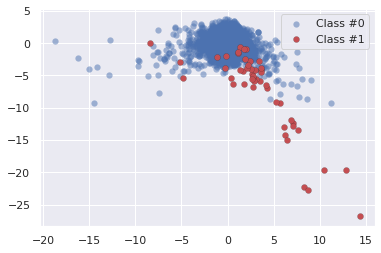

In [8]:
def prep_data(df):
    X = df.iloc[:, 1:29]
    X = np.array(X).astype(float)
    y = df.iloc[:, 29]
    y = np.array(y).astype(float)
    return X,y

# Define a function to create a scatter plot of our data and labels
def plot_data(X, y):
	plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
	plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", linewidth=0.15, c='r', edgecolor='k')
	plt.legend()
	return plt.show()

# Create X and y from the prep_data function 
X, y = prep_data(df)

# Plot our data by running our plot data function on X and y
plot_data(X, y)

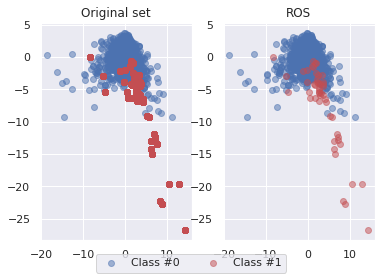

In [11]:
from imblearn.over_sampling import RandomOverSampler

method = RandomOverSampler()
X_resampled, y_resampled = method.fit_resample(X, y)
compare_plot(X_resampled, y_resampled, X, y, method='ROS')

## ถ้าใช้ ROS มันจะเห็นมีจุดเท่าเดิม แต่จริงๆมันคือก็อปปี้ค่าข้อมูลที่เหมือนเดิมเป๊ะๆขึ้นมา เลยเห็นมันมีอยู่เท่าเดิม

By visualizing your data you can immediately see how our fraud cases are scattered over our data, and how few are cases we have. A picture often makes the imbalance problem often very clear. In the next exercises we'll visually explore how to improve our fraud to non-fraud balance.

### ***Applying SMOTE***

Re-balance data using the ***Synthetic Minority Over-sampling Technique (SMOTE)***. Unlike ROS, SMOTE does not create exact copies of observations, but creates new, synthetic, samples that are quite similar to the existing observations in the minority class. SMOTE is therefore slightly more sophisticated than just copying observations, so let's apply SMOTE to our credit card data. The dataset `df` is available and the packages you need for SMOTE are imported. In the following exercise, you'll visualize the result and compare it to the original data, such that you can see the effect of applying SMOTE very clearly.

* Use the `prep_data` function on `df` to create features `X` and labels `y`.
* Define the resampling method as SMOTE of the regular kind, under the variable `method`.

* Use **`.fit_sample()`** on the original `X` and `y` to obtain newly resampled data.

* Plot the resampled data using the `plot_data()` function.

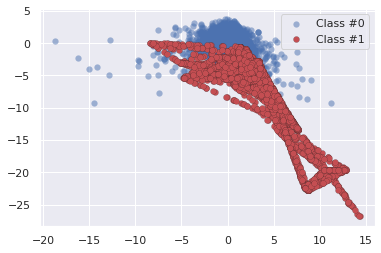

In [12]:
def prep_data(df):
    X = df.iloc[:, 1:29]
    X = np.array(X).astype(float)
    y = df.iloc[:, 29]
    y=np.array(y).astype(float)
    return X,y

def plot_data(X,y):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", linewidth=0.15, c='r', edgecolor='k')
    plt.legend()
    return plt.show()

from imblearn.over_sampling import SMOTE

# Run the prep_data function
X, y = prep_data(df)

# Define the resampling method
method = SMOTE()

# Create the resampled feature set
X_resampled, y_resampled = method.fit_resample(X, y)

# Plot the resampled data
plot_data(X_resampled, y_resampled)

 Minority class is now much more prominently visible in our data.

### ***Compare SMOTE to original data***

In the last exercise, you saw that using SMOTE suddenly gives us more observations of the minority class. Let's compare those results to our original data, to get a good feeling for what has actually happened. Let's have a look at the value counts again of our old and new data, and let's plot the two scatter plots of the data side by side. You'll use the function `compare_plot()` for that that, which takes the following arguments: `X`, `y`, `X_resampled`, `y_resampled`, `method=''`. The function plots your original data in a scatter plot, along with the resampled side by side.

* Print the value counts of our original labels, `y`. Be mindful that `y` is currently a Numpy array, so in order to use value counts, we'll assign `y` back as a pandas Series object.

* Repeat the step and print the value counts on `y_resampled`. This shows you how the balance between the two classes has changed with SMOTE.

* Use the `compare_plot()` function called on our original data as well our resampled data to see the scatterplots side by side.

0.0    5000
1.0      50
dtype: int64
0.0    5000
1.0    5000
dtype: int64


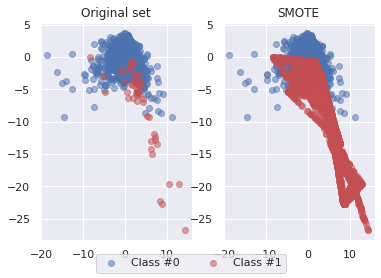

In [13]:
def compare_plot(X,y,X_resampled,y_resampled, method):
    # Start a plot figure
    f, (ax1, ax2) = plt.subplots(1, 2)
    # sub-plot number 1, this is our normal data
    c0 = ax1.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0",alpha=0.5)
    c1 = ax1.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1",alpha=0.5, c='r')
    ax1.set_title('Original set')
    # sub-plot number 2, this is our oversampled data
    ax2.scatter(X_resampled[y_resampled == 0, 0], X_resampled[y_resampled == 0, 1], label="Class #0", alpha=.5)
    ax2.scatter(X_resampled[y_resampled == 1, 0], X_resampled[y_resampled == 1, 1], label="Class #1", alpha=.5,c='r')
    ax2.set_title(method)
    # some settings and ready to go
    plt.figlegend((c0, c1), ('Class #0', 'Class #1'), loc='lower center',
                  ncol=2, labelspacing=0.)
    #plt.tight_layout(pad=3)
    return plt.show()

# Print the value_counts on the original labels y
print(pd.value_counts(pd.Series(y)))

# Print the value_counts
print(pd.value_counts(pd.Series(y_resampled)))

# Run compare_plot
compare_plot(X,y,X_resampled,y_resampled, method='SMOTE')

It should by now be clear that our SMOTE has balanced our data completely, and that the minority class is now equal in size to the majority class. Visualizing the data shows the effect on your data very clearly. In the next exercise, we'll demonstrate that there are multiple ways to implement SMOTE and that each method will have a slightly different effect.

### ***Exploring the traditional way to catch fraud***

Find fraud cases in our credit card dataset the "old way". First you'll define threshold values using common statistics, to split fraud and non-fraud. Then, use those thresholds on your features to detect fraud. This is common practice within fraud analytics teams.

Statistical thresholds are often determined by looking at the mean values of observations. Let's start this exercise by checking whether feature means differ between fraud and non-fraud cases. Then, you'll use that information to create common sense thresholds. Finally, you'll check how well this performs in fraud detection.

* Use **`.groupby()`** to group `df` on `Class` and obtain the mean of the features.

* Create the condition `V1` smaller than `-3`, and `V3` smaller than `-5` as a condition to flag fraud cases.

* As a measure of performance, use the **`crosstab`** function from pandas to compare our flagged fraud cases to actual fraud cases.

In [14]:
df['Class'].value_counts()

0    5000
1      50
Name: Class, dtype: int64

In [15]:
df = pd.read_csv("creditcard_sampledata_3.csv").drop(columns=['Unnamed: 0'])

# Get the mean for each group
print(df.groupby('Class').mean())

# Implement a rule for stating which cases are flagged as fraud
df['flag_as_fraud'] = np.where(np.logical_and((df['V1']<-3), (df['V3']<-5)), 1, 0)

# Create a crosstab of flagged fraud cases versus the actual fraud cases
pd.crosstab(df['Class'], df['flag_as_fraud'], rownames=['Actual Fraud'], colnames=['Flagged Fraud'])

             V1        V2        V3        V4        V5        V6        V7  \
Class                                                                         
0      0.035030  0.011553  0.037444 -0.045760 -0.013825 -0.030885  0.014315   
1     -4.985211  3.321539 -7.293909  4.827952 -3.326587 -1.591882 -5.776541   

             V8        V9       V10  ...       V20       V21       V22  \
Class                                ...                                 
0     -0.022432 -0.002227  0.001667  ... -0.002896 -0.010583 -0.010206   
1      1.395058 -2.537728 -5.917934  ...  0.194580  0.703182  0.069065   

            V23       V24       V25       V26       V27       V28      Amount  
Class                                                                          
0     -0.003305 -0.000918 -0.002613 -0.004651 -0.009584  0.002414   85.843714  
1     -0.088374 -0.029425 -0.073336 -0.023377  0.380072  0.009304  113.469000  

[2 rows x 29 columns]


Flagged Fraud,0,1
Actual Fraud,,
0,4984,16
1,28,22


With this rule, we detect 4 out of 17 fraud cases, but can't detect the other 13, and get 34 false positives. In the next exercise, we'll see how this measures up to a machine learning model.

### ***Using ML classification to catch fraud***

Remember, you've predicted 22 out of 50 fraud cases, and had 16 false positives.

So with that in mind, let's implement a Logistic Regression model. If you have taken the class on supervised learning in Python, you should be familiar with this model. If not, you might want to refresh that at this point. But don't worry, you'll be guided through the structure of the machine learning model.

The `X` and `y` variables are available in your workspace.

* Split `X` and `y` into training and test data, keeping 30% of the data for testing.

* Fit your model to your training data.

* Obtain the model predicted labels by running **`model.predict`** on `X_test`.

* Obtain a classification comparing `y_test` with predicted, and use the given confusion matrix to check your results.



In [16]:
df = pd.read_csv("creditcard_sampledata_3.csv").drop(columns=['Unnamed: 0'])
X, y = prep_data(df)

# Create the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fit a logistic regression model to our data
model = LogisticRegression(max_iter=9999)
model.fit(X_train, y_train)

# Obtain model predictions
predicted = model.predict(X_test)

# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test, predicted))

conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1505
         1.0       0.90      0.90      0.90        10

    accuracy                           1.00      1515
   macro avg       0.95      0.95      0.95      1515
weighted avg       1.00      1.00      1.00      1515

Confusion matrix:
 [[1504    1]
 [   1    9]]


* อย่างง ตัวเลขในตาราง confusion matrix เพราะว่ามันคือผลจากตัว holdout set
* You just ran your first fraud prediction model. Do you think these results are better than the rules based model? We are getting far fewer false positives, so that's an improvement. Also, we're catching a higher percentage of fraud cases, so that is also better than before. Do you understand why we have fewer observations to look at in the confusion matrix? ***Remember we are using only our test data to calculate the model results on.*** We're comparing the crosstab on the full dataset from the last exercise, with a confusion matrix of only 30% of the total dataset, so that's where that difference comes from. In the next chapter, we'll dive deeper into understanding these model performance metrics. Let's now explore whether we can improve the prediction results even further with resampling methods.

### ***Logistic regression combined with SMOTE***

You're going to take the Logistic Regression model from the previous exercise, and combine that with a **SMOTE** resampling method. We'll show you how to do that efficiently by using a pipeline that combines the resampling method with the model in one go. First, you need to define the pipeline that you're going to use.


* Import the **`Pipeline`** module from **`imblearn`**.

* Then define what you want to put into the pipeline, assign the **SMOTE** method with `borderline2` to `resampling`, and assign **`LogisticRegression()`** to the model.

* Combine two steps in the **`Pipeline()`** function. You need to state you want to combine resampling with the model in the respective place in the argument. 

In [17]:
# This is the pipeline module we need for this from imblearn
from imblearn.pipeline import Pipeline 

# Define which resampling method and which ML model to use in the pipeline
resampling = SMOTE()
model = LogisticRegression(max_iter=9999)

# Define the pipeline, tell it to combine SMOTE with the Logistic Regression model
pipeline = Pipeline([('SMOTE', resampling), ('Logistic Regression', model)])

You now know how to combine a model with a resampling method in a pipeline. Let's try and fit this pipeline onto the data in the next exercise.

### ***Using a pipeline***

Now that you have a pipeline defined, aka combining a logistic regression with a SMOTE method, let's run it on the data. You can treat the pipeline as if it were a single machine learning model. Our data `X` and `y` are already defined, and the `pipeline` is defined in the previous exercise. 

* Split the data `'X'` and `'y'` into the training and test set. Set aside `30`% of the data for a test set, and set the `random_state` to zero.
Fit your pipeline onto your training data and obtain the predictions by running the pipeline.predict() function on our X_test dataset.

In [18]:
# Split your data X and y, into a training and a test set and fit the pipeline onto the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fit your pipeline onto your training set and obtain predictions by fitting the model onto the test data 
pipeline.fit(X_train, y_train) 
predicted = pipeline.predict(X_test)

# Obtain the results from the classification report and confusion matrix 
print('Classifcation report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classifcation report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1505
         1.0       0.56      0.90      0.69        10

    accuracy                           0.99      1515
   macro avg       0.78      0.95      0.84      1515
weighted avg       1.00      0.99      1.00      1515

Confusion matrix:
 [[1498    7]
 [   1    9]]


 We now manage to find 90% cases of fraud, but we have a slightly higher number of false positives, albeit only 7 cases. Remember, not in all cases does resampling necessarily lead to better results. When the fraud cases are very spread and scattered over the data, using SMOTE can introduce a bit of bias. 
 
Nearest neighbors aren't necessarily also fraud cases, so the synthetic samples might 'confuse' the model slightly. In the next chapters, we'll learn how to also adjust our machine learning models to better detect the minority fraud cases.

### ***Natural hit rate***

Use credit card transaction data. The features and labels are similar to the data in the previous chapter, and the data is ***heavily imbalanced***. We've given you features `X` and labels `y` to work with already, which are both numpy arrays.

First you need to explore how prevalent fraud is in the dataset, to understand what the "natural accuracy" is, if we were to predict everything as non-fraud. It's is important to understand which level of "accuracy" you need to "beat" in order to get **a better prediction than by doing nothing**. In the following exercises, you'll create our first random forest classifier for fraud detection. That will serve as the "baseline" model that you're going to try to improve in the upcoming exercises.

* Count the total number of observations by taking the length of your labels `y`.

* Count the non-fraud cases in our data by using list comprehension on `y`; remember `y` is a NumPy array so **`.value_counts()`** cannot be used in this case.

* Calculate the natural accuracy by dividing the non-fraud cases over the total observations.

* Print the percentage.

In [21]:
df = pd.read_csv("creditcard_sampledata_2.csv").drop(columns=['Unnamed: 0'])
X, y = prep_data(df)

# Count the total number of observations from the length of y
total_obs = len(y)

# Count the total number of non-fraudulent observations 
non_fraud = [i for i in y if i == 0]
count_non_fraud = non_fraud.count(0)

# Calculate the percentage of non fraud observations in the dataset
percentage = (float(count_non_fraud)/float(total_obs)) * 100

# Print the percentage: this is our "natural accuracy" by doing nothing
print(percentage)

95.8904109589041


This tells us that by doing nothing, we would be correct in 95.9% of the cases. So now you understand, that if we get an accuracy of less than this number, our model does not actually add any value in predicting how many cases are correct. Let's see how a random forest does in predicting fraud in our data.

### ***Random Forest Classifier - part 1***

Let's now create a first random forest classifier for fraud detection. Hopefully you can do better than the baseline accuracy you've just calculated, which was roughly 96%. This model will serve as the "baseline" model that you're going to try to improve in the upcoming exercises. Let's start first with splitting the data into a test and training set, and defining the Random Forest model. The data available are features `X` and labels `y`.

* Import the random forest classifier from **`sklearn`**.

* Split your features `X` and labels `y` into a training and test set. Set aside a test set of 30%.

* Assign the random forest classifier to model and keep `random_state` at `5`. We need to set a random state here in order to be able to compare results across different models.

In [23]:
# Import the random forest model from sklearn
from sklearn.ensemble import RandomForestClassifier

# Split your data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Define the model as the random forest
model = RandomForestClassifier(random_state=5)

### ***Random Forest Classifier - part 2***

Let's see how our Random Forest model performs without doing anything special to it. The model from the previous exercise is available, and you've already split your data in `X_train`, `y_train`, `X_test`, `y_test`.

* Fit the earlier defined `model` to our training data and obtain predictions by getting the model predictions on `X_test`.

* Obtain and print the accuracy score by comparing the actual labels `y_test` with our predicted labels `predicted`.

In [26]:
# Fit the model to our training set
model.fit(X_train, y_train)

# Obtain predictions from the test data 
predicted = model.predict(X_test)

# Print the accuracy performance metric
print(accuracy_score(y_test, predicted))

0.991324200913242


Random Forest prevents overfitting most of the time, by creating random subsets of the features and building smaller trees using these subsets. Afterwards, it combines the subtrees of subsamples of features, so it does not tend to overfit to your entire feature set the way "deep" Decisions Trees do.

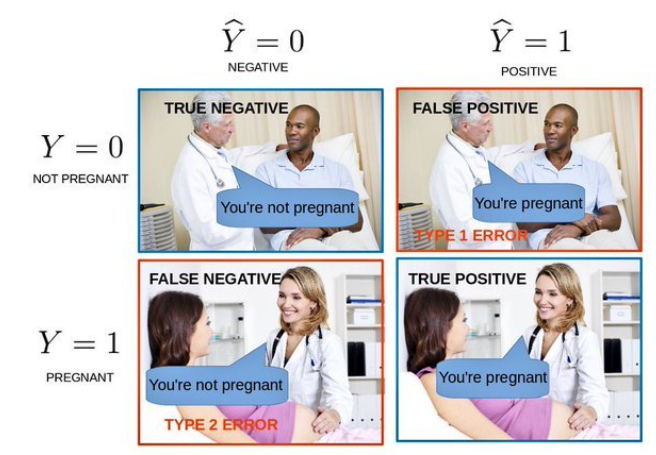

# ***Precision and Recall***

$$Precision = \frac{\# True \ Positives}{\# True \ Positives + \# False \ Positives}$$

$$Recall = \frac{\# True \ Positives}{\# True \ Positives + \# False \ Negatives}$$ 

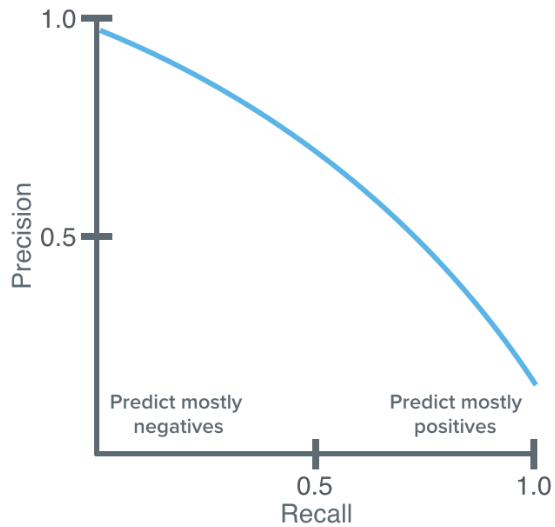

$$F-Measure = \frac{2 \times Precision \times Recall}{Precision + Recall} = \frac{2 \times TP}{2 \times TP + FP + FN}$$

# ***Obtaining performance metrics***

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Calculate average precision and the PR curve
average_precision = average_precision_score(y_test, predicted)

# Obtain precision and recall
precision, recall, _ = precision_recall_curve(y_test, predicted)

# ***Precision-recall Curve***

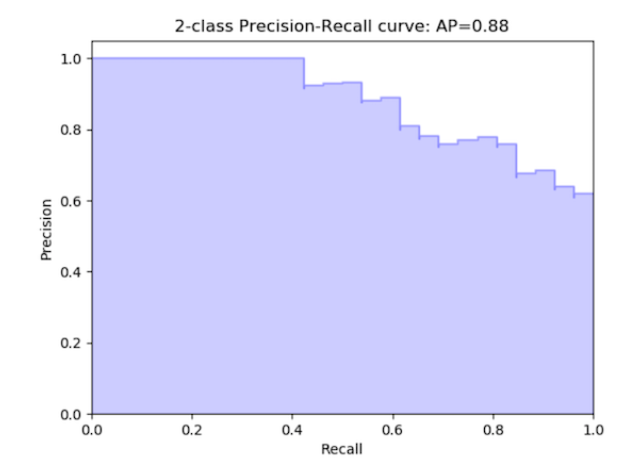

### ***Performance metrics for the RF model***

In the previous exercises you obtained an accuracy score for your random forest model. This time, we know accuracy can be misleading in the case of fraud detection. With highly imbalanced fraud data, the AUROC curve is a more reliable performance metric, used to compare different classifiers. Moreover, the classification report tells you about the precision and recall of your model, whilst the confusion matrix actually shows how many fraud cases you can predict correctly. So let's get these performance metrics.

You'll continue working on the same random forest model from the previous exercise. Your model, defined as `model = RandomForestClassifier(random_state=5)` has been fitted to your training data already, and `X_train`, `y_train`, `X_test`, `y_test` are available.

* Import the classification report, confusion matrix and ROC score from **`sklearn.metrics`**.

* Get the binary predictions from your trained random forest model.

* Get the predicted probabilities by running the **`.predict_proba()`** method.

* Obtain classification report and confusion matrix by comparing `y_test` with `predicted`.

In [28]:
# Import the packages to get the different performance metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Obtain the predictions from our random forest model 
predicted = model.predict(X_test)

# Predict probabilities
probs = model.predict_proba(X_test)

# Print the ROC curve, classification report and confusion matrix
print(roc_auc_score(y_test, probs[:,1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

0.9629729489186374
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      2099
         1.0       0.99      0.80      0.88        91

    accuracy                           0.99      2190
   macro avg       0.99      0.90      0.94      2190
weighted avg       0.99      0.99      0.99      2190

[[2098    1]
 [  18   73]]


You have now obtained more meaningful performance metrics that tell us how well the model performs, given the highly imbalanced data that you're working with. The model predicts 74 cases of fraud, out of which 73 are actual fraud. You have only 1 false positives. This is really good, and as a result you have a very high precision score. You do however, don't catch 18 cases of actual fraud. ***Recall is therefore not as good as precision***. Let's try to improve that in the followings.

### ***Plotting the Precision Recall Curve***

You can also plot a Precision-Recall curve, to investigate the trade-off between the two in your model. In this curve Precision and Recall are inversely related; as Precision increases, Recall falls and vice-versa. A balance between these two needs to be achieved in your model, otherwise you might end up with many false positives, or not enough actual fraud cases caught. To achieve this and to compare performance, the precision-recall curves come in handy.

Your Random Forest Classifier is available as `model`, and the predictions as `predicted`. You can simply obtain the average precision score and the PR curve from the **`sklearn`** package. The function `plot_pr_curve()` plots the results for you. 

* Calculate the average precision by running the function on the actual labels `y_test` and your predicted labels `predicted`.

* Run the `precision_recall_curve()` function on the same arguments `y_test` and `predicted` and plot the curve.


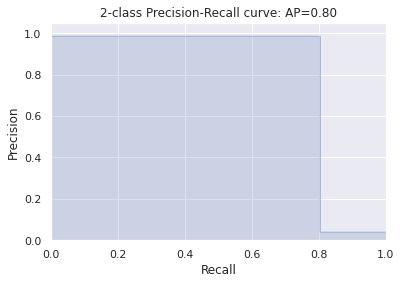

In [29]:
def plot_pr_curve(recall, precision, average_precision):
  plt.step(recall, precision, color='b', alpha=0.2, where='post')
  plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
  plt.show()

# Calculate average precision and the PR curve
average_precision = average_precision_score(y_test, predicted)

# Obtain precision and recall 
precision, recall, _ = precision_recall_curve(y_test, predicted)

# Plot the recall precision tradeoff
plot_pr_curve(recall, precision, average_precision)

The benefit of the performance metric ROC curve (AUROC) versus Precision and Recall is that the ROC curve plots the true positives vs. false positives , for a classifier, as its discrimination threshold is varied. Since, a random method describes a horizontal curve through the unit interval, it has an AUC of 0.5. Minimally, classifiers should perform better than this, and the extent to which they score higher than one another (meaning the area under the ROC curve is larger), they have better expected performance.

# ***Balanced weights***

In [ ]:
model = RandomForestClassifier(class_weight='balanced')

model = RandomForestClassifier(class_weight='balanced_subsample')

model = LogisticRegression(class_weight='balanced')

model = SVC(kernel='linear', class_weight='balanced', probability=True)

# ***Hyperparameter tuning for fraud detection***

In [ ]:
model = RandomForestClassifier(class_weight={0:1,1:4},random_state=1)

model = LogisticRegression(class_weight={0:1,1:4}, random_state=1)

model = RandomForestClassifier(n_estimators=10,
                               criterion='gini',
                               max_depth=None,
                               min_samples_split=2,
                               min_samples_leaf=1,
                               max_features='auto',
                               n_jobs=-1,
                               class_weight=None)

# ***Using GridSearchCV***


In [ ]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid
param_grid = {'max_depth': [80, 90, 100, 110],
              'max_features': [2, 3],
              'min_samples_leaf': [3, 4, 5],
              'min_samples_split': [8, 10, 12],
              'n_estimators': [100, 200, 300, 1000]}

# Define which model to use
model = RandomForestRegressor()

# Instantiate the grid search model
grid_search_model = GridSearchCV(estimator=model, 
                                 param_grid=param_grid, 
                                 cv=5, 
                                 n_jobs=-1, 
                                 scoring='f1') # For Fraud, use any other thing that is not accuracy

# Fit the grid search to the data
grid_search_model.fit(X_train, y_train)

# Get the optimal parameters
grid_search_model.best_params_



```
{'bootstrap': True,
'max_depth': 80,
'max_features': 3,
'min_samples_leaf': 5,
'min_samples_split': 12,
'n_estimators': 100}
```



In [ ]:
# Get the best_estimator results
grid_search.best_estimator_
grid_search.best_score_

### ***Model adjustments***

A simple way to adjust the random forest model to deal with highly imbalanced fraud data, is to use the **`class_weights`** option when defining your sklearn model. However, as you will see, it is a bit of a blunt force mechanism and might not work for your very special case.

In this exercise you'll explore the **`weight="balanced_subsample"`** mode the Random Forest model from the earlier exercise. You already have split your data in a training and test set, i.e `X_train`, `X_test`, `y_train`, `y_test` are available. The metrics function have already been imported.

* Set the **`class_weight`** argument of your classifier to **`balanced_subsample`**.

* Fit your model to your training set.

* Obtain predictions and probabilities from `X_test`.

* Obtain the **`roc_auc_score`**, the classification report and confusion matrix.

In [31]:
# Define the model with balanced subsample
model = RandomForestClassifier(class_weight='balanced_subsample', random_state=5)

# Fit your training model to your training set
model.fit(X_train, y_train)

# Obtain the predicted values and probabilities from the model 
predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

# Print the roc_auc_score, the classification report and confusion matrix
print(roc_auc_score(y_test, probs[:, 1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

0.9750299724096771
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      2099
         1.0       0.99      0.80      0.88        91

    accuracy                           0.99      2190
   macro avg       0.99      0.90      0.94      2190
weighted avg       0.99      0.99      0.99      2190

[[2098    1]
 [  18   73]]


You can see that the model results don't change at all.  (บนดาต้าแคมพ์เปลี่ยนบ้างนิดหน่อย)

If we mostly care about catching fraud, and not so much about the false positives, this does actually not improve our model at all, albeit a simple option to try. In the next exercises you'll see how to more smartly tweak your model to focus on **reducing false negatives** and catch more fraud.

### ***Adjusting your Random Forest to fraud detection***

In this exercise you're going to dive into the options for the random forest classifier, as we'll assign weights and tweak the shape of the decision trees in the forest. You'll define weights manually, to be able to off-set that imbalance slightly. In our case we have 300 fraud to 7000 non-fraud cases, so by setting the weight ratio to `1:12`, we get to a `1/3` fraud to `2/3` non-fraud ratio, which is good enough for training the model on.

The data in this exercise has already been split into training and test set, so you just need to focus on defining your model. You can then use the function `get_model_results()` as a short cut. This function fits the model to your training data, predicts and obtains performance metrics similar to the steps you did in the previous exercises.

* Change the weight option to set the ratio to `1` to `12` for the non-fraud and fraud cases, and set the split criterion to `'entropy'`.

* Set the maximum depth to `10`.

* Set the minimal samples in leaf nodes to `10`.

* Set the number of trees to use in the model to `20`.

In [32]:
def get_model_results(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    probs = model.predict_proba(X_test)
    print (classification_report(y_test, predicted))
    print (confusion_matrix(y_test, predicted))

# Change the model options
model = RandomForestClassifier(bootstrap=True, class_weight={0:1, 1:12}, 
                               criterion='entropy',
                               max_depth=10,
                               min_samples_leaf=10, 
                               n_estimators=20, 
                               n_jobs=-1, 
                               random_state=5)

# Run the function get_model_results
get_model_results(X_train, y_train, X_test, y_test, model)

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      2099
         1.0       0.97      0.85      0.91        91

    accuracy                           0.99      2190
   macro avg       0.98      0.92      0.95      2190
weighted avg       0.99      0.99      0.99      2190

[[2097    2]
 [  14   77]]


You can see by smartly defining more options in the model, you can obtain better predictions. You have effectively reduced the number of false negatives, i.e. you are catching more cases of fraud, whilst keeping the number of false positives low. In this exercise you've manually changed the options of the model. There is a smarter way of doing it, by using **`GridSearchCV`**, which you'll see in the next exercise!

### ***GridSearchCV to find optimal parameters***

In this exercise you're going to tweak our model in a less "random" way, but use **`GridSearchCV`** to do the work for you.

With **`GridSearchCV`** you can define which performance metric to score the options on. Since for fraud detection we are mostly interested in catching as many fraud cases as possible, you can optimize your model settings to get the best possible **`Recall`** score. If you also cared about reducing the number of false positives, you could optimize on **`F1-score`**, this gives you that nice Precision-Recall trade-off.

**`GridSearchCV`** has already been imported from **`sklearn.model_selection`**, so let's give it a try!

* Define in the parameter grid that you want to try `1` and `30` trees, and that you want to try the `gini` and `entropy` split criterion.

* Define the model to be simple **`RandomForestClassifier`**, you want to keep the `random_state` at `5` to be able to compare models.

* Set the scoring option such that it optimizes for **`recall`**.

* Fit the model to the training data `X_train` and `y_train` and obtain the best parameters for the model.

In [42]:
# Define the parameter sets to test
param_grid = {'n_estimators': [1, 30], 'max_features': ['auto', 'log2'],  'max_depth': [4, 8], 'criterion': ['gini', 'entropy']}

# Define the model to use
model = RandomForestClassifier(class_weight={0:1,1:12}, random_state=5, min_samples_leaf=10, n_jobs=-1)

# Combine the parameter sets with the defined model
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)

# Fit the model to our training data and obtain best parameters
CV_model.fit(X_train, y_train)
CV_model.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 1}

In [39]:
CV_model.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 30}

In [43]:
CV_model.best_estimator_.fit(X_train, y_train)
predicted = CV_model.best_estimator_.predict(X_test)
probs = CV_model.best_estimator_.predict_proba(X_test)
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      2099
         1.0       0.54      0.82      0.65        91

    accuracy                           0.96      2190
   macro avg       0.77      0.90      0.82      2190
weighted avg       0.97      0.96      0.97      2190

[[2035   64]
 [  16   75]]


### ***Model results using GridSearchCV***

You discovered that the best parameters for your model are that the split criterion should be set to **`'gini'`**, the number of estimators (trees) should be `30`, the maximum depth of the model should be `4` and the maximum features should be set to `"auto"`.

Let's give this a try and see how well our model performs. You can use the `get_model_results()` function again to save time.

* Input the optimal settings into the model definition.

* Fit the model, obtain predictions and get the performance parameters with `get_model_results()`.

In [41]:
def get_model_results(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    probs = model.predict_proba(X_test)
    print (classification_report(y_test, predicted))
    print (confusion_matrix(y_test, predicted))

# Input the optimal parameters in the model
model = RandomForestClassifier(class_weight={0:1,1:12}, criterion='gini',
            max_depth=4, max_features='auto',  min_samples_leaf=10, n_estimators=30, n_jobs=-1, random_state=5)

# Get results from your model
get_model_results(X_train, y_train, X_test, y_test, model)

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      2099
         1.0       0.97      0.82      0.89        91

    accuracy                           0.99      2190
   macro avg       0.98      0.91      0.94      2190
weighted avg       0.99      0.99      0.99      2190

[[2097    2]
 [  16   75]]


You've managed to improve your model even further. The number of false positives has now been slightly reduced even further, which means we are catching more cases of fraud. However, you see that the number of false positives actually went up. That is that Precision-Recall trade-off in action. To decide which final model is best, you need to take into account how bad it is not to catch fraudsters, versus how many false positives the fraud analytics team can deal with. Ultimately, this final decision should be made by you and the fraud team together.



In [ ]:
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()

ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], 
                                  voting='hard') # Use predicted class labels and take the majority vote
                                  # Another rule is 'soft'
ensemble_model.fit(X_train, y_train)
ensemble_model.predict(X_test)

VotingClassifier(estimators=[('lr', clf1), ('rf', clf2),('gnb', clf3)], voting='soft', 
                 weights=[2,1,1]) # ใส่ค่าน้ำหนักความสำคัญ

### ***Logistic Regression***

In this last lesson you'll combine three algorithms into one model with the **`VotingClassifier`**. This allows us to benefit from the different aspects from all models, and hopefully improve overall performance and detect more fraud. The first model, the Logistic Regression, has a slightly higher recall score than our optimal Random Forest model, but gives a lot more false positives. You'll also add a Decision Tree with balanced weights to it. The data is already split into a training and test set, i.e. `X_train`, `y_train`, `X_test`, `y_test` are available.

In order to understand how the Voting Classifier can potentially improve your original model, you should check the standalone results of the Logistic Regression model first.

* Define a **`LogisticRegression`** model with class weights that are` 1:15` for the fraud cases.
* Fit the model to the training set, and obtain the model predictions.
* Print the classification report and confusion matrix.

In [51]:
# Define the Logistic Regression model with weights
model = LogisticRegression(class_weight={0:1, 1:15}, random_state=5, max_iter=9999)

# Get the model results
get_model_results(X_train, y_train, X_test, y_test, model)

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      2099
         1.0       0.62      0.87      0.72        91

    accuracy                           0.97      2190
   macro avg       0.81      0.92      0.86      2190
weighted avg       0.98      0.97      0.97      2190

[[2051   48]
 [  12   79]]


As you can see the Logistic Regression has quite different performance from the Random Forest. More false positives, but also a better `Recall`. It will therefore will a useful addition to the Random Forest in an ensemble model. Let's give that a try.

### ***Voting Classifier***

Let's now combine three machine learning models into one, to improve our Random Forest fraud detection model from before. You'll combine our usual Random Forest model, with the Logistic Regression from the previous exercise, with a simple Decision Tree. You can use the short cut `get_model_results()` to see the immediate result of the ensemble model.

* Import the Voting Classifier package.

* Define the three models; use the Logistic Regression from before, the Random Forest from previous exercises and a Decision tree with balanced class weights.

* Define the ensemble model by inputting the three classifiers with their respective labels.

In [57]:
# Import the package
from sklearn.ensemble import VotingClassifier

# Define the three classifiers to use in the ensemble
clf1 = LogisticRegression(class_weight={0:1, 1:15}, random_state=5, max_iter=9999)
clf2 = RandomForestClassifier(class_weight={0:1, 1:12}, criterion='gini', max_depth=8, max_features='log2',
            min_samples_leaf=10, n_estimators=30, n_jobs=-1, random_state=5)
clf3 = DecisionTreeClassifier(random_state=5, class_weight="balanced")

# Combine the classifiers in the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3)], 
                                  voting='soft') # ไม่รู้ทำไมเวอร์ชันนี้ hard ไม่ได้

# Get the results 
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      2099
         1.0       0.91      0.86      0.88        91

    accuracy                           0.99      2190
   macro avg       0.95      0.93      0.94      2190
weighted avg       0.99      0.99      0.99      2190

[[2091    8]
 [  13   78]]


You see that by combining the classifiers, you can take the best of multiple models. You've increased the cases of fraud you are catching from 76 to 78, and you only have 8 false positives in return. If you do care about catching as many fraud cases as you can, whilst keeping the false positives low, this is a pretty good trade-off.
 
 * The Logistic Regression as a standalone was quite bad in terms of false positives, and 
 * the Random Forest was worse in terms of false negatives. 
 
 By combining these together you indeed managed to improve performance.

### ***Adjust weights within the Voting Classifier***

You've just seen that the Voting Classifier allows you to improve your fraud detection performance, by combining good aspects from multiple models. Now let's try to adjust the weights we give to these models. By increasing or decreasing weights you can play with how much emphasis you give to a particular model relative to the rest. This comes in handy when a certain model has overall better performance than the rest, but you still want to combine aspects of the others to further improve your results.

For this exercise the data is already split into a training and test set, and `clf1`, `clf2` and `clf3` are available and defined as before, i.e. they are the Logistic Regression, the Random Forest model and the Decision Tree respectively.

* Define an ensemble method where you over weigh the second classifier (`clf2`) with `4` to `1` to the rest of the classifiers.

* Fit the model to the training and test set, and obtain the predictions predicted from the ensemble model.

* Print the performance metrics, this is ready for you to run.





In [58]:
# Define the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft', weights=[1, 4, 1], flatten_transform=True)

# Get results 
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      2099
         1.0       0.94      0.85      0.89        91

    accuracy                           0.99      2190
   macro avg       0.97      0.92      0.94      2190
weighted avg       0.99      0.99      0.99      2190

[[2094    5]
 [  14   77]]


The weight option allows you to play with the individual models to get the best final mix for your fraud detection model. Now that you have finalized fraud detection with supervised learning, let's have a look at how fraud detetion can be done when you don't have any labels to train on.

### ***Exploring your data***

In the next exercises, you will be looking at bank **payment transaction data**. The financial transactions are categorized by type of expense, as well as the amount spent. Moreover, you have some client characteristics available such as **age group** and **gender**. Some of the transactions are labelled as fraud; you'll treat these labels as given and will use those to validate the results.

When using unsupervised learning techniques for fraud detection, you want to distinguish normal from abnormal (thus potentially fraudulent) behavior. As a fraud analyst to understand what is "normal", you need to have a good understanding of the data and its characteristics. 

* Obtain the shape of the dataframe df to inspect the size of our data and 
* display the first rows to see which features are available.
* Group the data by transaction category and take the mean of the data.

In [2]:
df = pd.read_csv('banksim.csv').drop(columns='Unnamed: 0')

# Get the dataframe shape
print(df.shape)

# Display the first 5 rows
display(df.head())

# Groupby categories and take the mean
print(df.groupby('category').mean())

(7200, 5)


,age,gender,category,amount,fraud
0,3,F,es_transportation,49.71,0
1,4,F,es_health,39.29,0
2,3,F,es_transportation,18.76,0
3,4,M,es_transportation,13.95,0
4,2,M,es_transportation,49.87,0


                           amount     fraud
category                                   
es_barsandrestaurants   43.841793  0.022472
es_contents             55.170000  0.000000
es_fashion              59.780769  0.020619
es_food                 35.216050  0.000000
es_health              126.604704  0.242798
es_home                120.688317  0.208333
es_hotelservices       172.756245  0.548387
es_hyper                46.788180  0.125000
es_leisure             229.757600  1.000000
es_otherservices       149.648960  0.600000
es_sportsandtoys       157.251737  0.657895
es_tech                132.852862  0.179487
es_transportation       27.422014  0.000000
es_travel              231.818656  0.944444
es_wellnessandbeauty    66.167078  0.060606


There is relatively more fraud in the travel, sports and leisure categories. 

### ***Customer segmentation***

You're going to check whether there are any obvious patterns for the clients in this data, thus whether you need to segment your data into groups, or whether the data is rather homogenous.

You unfortunately don't have a lot client information available; you can't for example distinguish between the wealth levels of different clients. However, there is data on **age** available, so let's see whether there is any significant difference between behavior of age groups.

* Group the dataframe `df` by the `age` category and get the means for each age group.
* Count the values of each age group.

In [65]:
# Group by age groups and get the mean
display(df.groupby('age').mean())

# Count the values of the observations in each age group
print(df['age'].value_counts())

,amount,fraud
age,,
0,49.468935,0.050000
1,35.622829,0.026648
2,37.228665,0.028718
3,37.279338,0.023283
4,36.197985,0.035966
5,37.547521,0.023990
6,36.700852,0.022293
U,39.117000,0.000000


2    2333
3    1718
4    1279
5     792
1     713
6     314
0      40
U      11
Name: age, dtype: int64


Although age group '0' is indeed a bit different from the rest, only 40 cases in the entire dataset fall in this category, so it would not be feasible to split these out into a seperate group and run a model on that amount of observations. You have to keep in mind that you need to train the model seperately on each segment, so in this case it would not be possible.

### ***Using statistics to define normal behavior***'

In the previous exercises we saw that fraud is more prevalent in certain transaction categories, but that there is no obvious way to segment our data into for example age groups. This time, let's investigate the average amounts spend in normal transactions versus fraud transactions. This gives you an idea of how fraudulent transactions differ structurally from normal transactions.

* Create two new dataframes from fraud and non-fraud observations. Locate the data in `df` with **`.loc`** and assign the condition "where fraud is 1" and "where fraud is 0" for creation of the new dataframes.

* Plot the `amount` column of the newly created dataframes in the histogram plot functions and assign the labels `fraud` and `nonfraud` respectively to the plots.

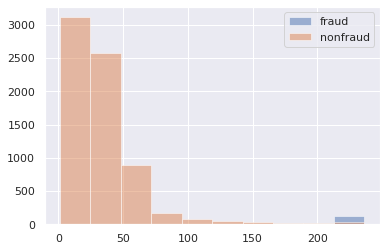

In [66]:
# Create two dataframes with fraud and non-fraud data 
df_fraud = df.loc[df['fraud'] == 1] 
df_non_fraud = df.loc[df['fraud'] == 0]

# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(df_fraud['amount'], alpha=0.5, label='fraud')
plt.hist(df_non_fraud['amount'], alpha=0.5, label='nonfraud')
plt.legend()
plt.show()

As the number fraud observations is much smaller, it is difficult to see the full distribution. Nonetheless, you can see that the fraudulent transactions tend to be on the larger side relative to normal obervations. This is good news, as it helps us later in detecting fraud from non-fraud. In the next chapter you're going to implement a clustering model to distinguish between normal and abnormal transactions, ***when the fraud labels are no longer available.***

# ***K-means clustering in Python***



In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# Transform and scale your data
X = np.array(df).astype(np.float)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Define the k-means model and fit to the data
kmeans = KMeans(n_clusters=6, random_state=42).fit(X_scaled)

# ***The right amount of clusters***

In [ ]:
clust = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in clust]
score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

plt.plot(clust,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

### ***Scaling the data***

For ML algorithms <ins>***using distance based metrics***</ins>, it is <ins>***crucial to always scale your data***</ins>, as features using different scales will distort your results. **K-means** uses the Euclidian distance to assess distance to cluster centroids, therefore you first need to scale your data before continuing to implement the algorithm. Let's do that first.

Available is the dataframe `df` from the previous exercise, with some minor data preparation done so it is ready for you to use with `sklearn`. The fraud labels are separately stored under `labels`, you can use those to check the results later. `numpy` has been imported as `np`.

* Import the **`MinMaxScaler`**.

* Transform your dataframe `df` into a `numpy` array `X` by taking only the values of `df` and make sure you have all `float` values.

* Apply the defined scaler onto `X` to obtain scaled values of `X_scaled` to force all your features to a `0-1` scale.

In [9]:
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('banksim_adj.csv').drop(columns='Unnamed: 0')
X, y = df.drop(columns='fraud'), df['fraud'].values.astype(float)

# Take the float values of df for X
X = df.values.astype(float)

# Define the scaler and apply to the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Our dataset is now ready to be used in the K-means clustering algorithm.

### ***K-means clustering***

A very commonly used clustering algorithm is **K-means clustering**. For fraud detection, **K-means clustering** is straightforward to implement and relatively powerful in predicting suspicious cases. It is a good algorithm to start with when working on fraud detection problems. However, fraud data is oftentimes very large, especially when you are working with transaction data. <ins>***MiniBatch K-means***</ins> is an efficient way to implement K-means on a large dataset, which you will use in this exercise.

The scaled data from the previous exercise, `X_scaled` is available. 

* Import **`MiniBatchKMeans`** from **`sklearn`**.
* Initialize the minibatch kmeans model with 8 clusters.
* Fit the model to your scaled data.

In [ ]:
# Import MiniBatchKmeans 
from sklearn.cluster import MiniBatchKMeans

# Define the model 
kmeans = MiniBatchKMeans(n_clusters=8, random_state=0)

# Fit the model to the scaled data
kmeans.fit(X_scaled)

You have now fitted your ***MiniBatch K-means*** model to the data. Next, you're going to explore whether this model is any good at flagging fraud. But before doing that, you still need to figure our what the right number of clusters to use is. 

### ***Elbow method***

You've implemented **MiniBatch K-means** with `8` clusters, without actually checking what the right amount of clusters should be. For our first fraud detection approach, <ins>*it is important to get the number of clusters right*</ins>, especially when you want to use the outliers of those clusters as fraud predictions. To decide which amount of clusters you're going to use, let's apply the **Elbow method** and see what the optimal number of clusters should be based on this method.

`X_scaled` is again available for you to use and **`MiniBatchKMeans`** has been imported from **`sklearn`**.

* Define the range to be between `1` and `10` clusters.
* Run **MiniBatch K-means** on all the clusters in the range using list comprehension.

* Fit each model on the scaled data and obtain the scores from the scaled data.

* Plot the cluster numbers and their respective scores.

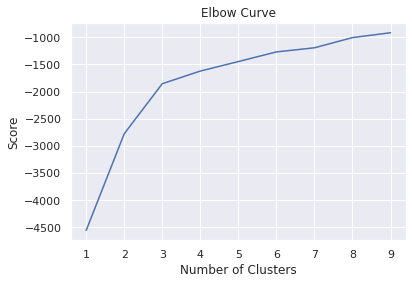

In [8]:
# Define the range of clusters to try
clustno = range(1, 10)

# Run MiniBatch Kmeans over the number of clusters
kmeans = [MiniBatchKMeans(n_clusters=i) for i in clustno]

# Obtain the score for each model
score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

# Plot the models and their respective score 
plt.plot(clustno, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Now you can see that the optimal number of clusters should probably be at around 3 clusters, as that is where the elbow is in the curve. We'll use this in the next exercise as our baseline model, and see how well this does in detecting fraud.

# ***Identifying fraud from outliers***

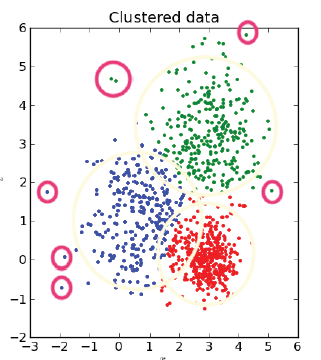

In [ ]:
# Run the kmeans model on scaled data
kmeans = KMeans(n_clusters=6, random_state=42,n_jobs=-1).fit(X_scaled)

# Get the cluster number for each datapoint
X_clusters = kmeans.predict(X_scaled)

# Save the cluster centroids
X_clusters_centers = kmeans.cluster_centers_

# Calculate the distance to the cluster centroid for each point
dist = [np.linalg.norm(x-y) for x,y in zip(X_scaled, X_clusters_centers[X_clusters])]

# Create predictions based on distance
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 93)] = 1
km_y_pred[dist <  np.percentile(dist, 93)] = 0

### ***Detecting outliers***

Use the K-means algorithm to predict fraud, and compare those predictions to the actual labels that are saved, to sense check our results.

The fraudulent transactions are typically flagged as the observations that are furthest aways from the cluster centroid. You'll learn how to do this and how to determine the cut-off in this exercise. In the next one, you'll check the results.

Available are the scaled observations `X_scaled`, as well as the labels stored under the variable `y`.

* Split the scaled data and labels `y` into a train and test set.

* Define the **MiniBatch K-means** model with `3` clusters, and fit to the training data.

* Get the cluster predictions from your test data and obtain the cluster centroids.

* Define the boundary between fraud and non fraud to be at 95% of distance distribution and higher.

In [3]:
# ทำข้อมูลให้เหมือนไฟล์ banksim_adj.csv

df2 = pd.read_csv('banksim.csv').drop(columns='Unnamed: 0')
df2 = df2[df2['age']!='U']
df2['age'] = df2['age'].astype(int)
df2 = pd.get_dummies(df2)
df2.drop(columns=['gender_F', 'gender_U', 'category_es_wellnessandbeauty'], inplace=True)
for col in df2.columns:
    if 'category_' in col:
        df2.rename(columns={col:col[9:]}, inplace=True)
df2.rename(columns={'gender_M': 'M'}, inplace=True)
df2['M'] = df2['M'].astype(int)
for i in df2.columns[4:]:
    df2[i] = df2[i].astype(int)
X, y = df2.drop(columns='fraud').values.astype(float), df2['fraud'].values.astype(float)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)

# Define K-means model 
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42).fit(X_train)

# Obtain predictions and calculate distance from cluster centroid
X_test_clusters = kmeans.predict(X_test)
X_test_clusters_centers = kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x, y in zip(X_test, X_test_clusters_centers[X_test_clusters])]

# Create fraud predictions based on outliers on clusters 
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 95)] = 1
km_y_pred[dist < np.percentile(dist, 95)] = 0

### ***Checking model results***

In the previous exercise you've flagged all observations to be fraud, if they are in the top 5th percentile in distance from the cluster centroid. I.e. these are the very outliers of the three clusters. For this exercise you have the scaled data and labels already split into training and test set, so `y_test` is available. The predictions from the previous exercise, `km_y_pred`, are also available. Let's create some performance metrics and see how well you did.

* Obtain the area under the ROC curve from your test labels and predicted labels.

* Obtain the confusion matrix from the test labels and predicted labels and plot the results.



0.8197704982668266
[[2030   69]
 [  19   39]]


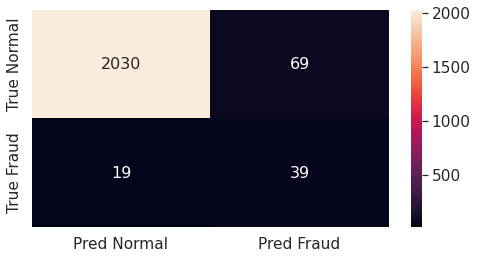

In [71]:
def plot_confusion_matrix(km_cm):
    df_cm = pd.DataFrame(km_cm, ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
    plt.figure(figsize = (8,4))
    sns.set(font_scale=1.4) 
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')
    plt.show()

# Obtain the ROC score
print(roc_auc_score(y_test, km_y_pred))

# Create a confusion matrix
km_cm = confusion_matrix(y_test, km_y_pred)

print(km_cm)

# Plot the confusion matrix in a figure to visualize results 
plot_confusion_matrix(km_cm)

If you were to decrease the percentile used as a cutoff point in the previous exercise to 93% instead of 95%, what would that do to your prediction results?

By lowering the threshold for cases flagged as fraud, you flag more cases overall but thereby also get more false positives.

# ***DBSCAN***


In [ ]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.5, min_samples=10, n_jobs=-1).fit(X_scaled)

# Get the cluster labels (aka numbers)
pred_labels = db.labels_

# Count the total number of clusters
n_clusters_ = len(set(pred_labels)) - (1 if -1 in pred_labels else 0)

# Print model results
print('Estimated number of clusters: %d' % n_clusters_)

```
Estimated number of clusters: 31
```



In [ ]:
# Print model results
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_scaled, pred_labels))



```
Silhouette Coefficient: 0.359
```

# ***Checking the size of the clusters***



In [ ]:
# Get sample counts in each cluster
counts = np.bincount(pred_labels[pred_labels>=0])
print (counts)



```
[ 763 496 840 355 1086 676 63 306 560 134 28 18 262 128 332 22
22 13 31 38 36 28 14 12 30 10 11 10 21 10 5]
```



### ***DBSCAN***

In this exercise you're going to explore using a density based clustering method (DBSCAN) to detect fraud. The advantage of DBSCAN is that <ins>***you do not need to define the number of clusters beforehand.***</ins> Also, DBSCAN can handle weirdly shaped data (i.e. non-convex) much better than K-means can. This time, you are not going to take the outliers of the clusters and use that for fraud, but take the smallest clusters in the data and label those as fraud. You again have the scaled dataset, i.e. `X_scaled` available. Let's give it a try!

* Initialize a **`DBSCAN`** model setting the maximum distance between two samples to `0.9` and the minimum observations in the clusters to `10`, and fit the model to the scaled data.

* Obtain the predicted labels, these are the cluster numbers assigned to an observation.

* Print the number of clusters and the rest of the performance metrics.

In [15]:
# Import DBSCAN
from sklearn.cluster import DBSCAN

# Initialize and fit the DBSCAN model
db = DBSCAN(eps=0.9, min_samples=10, n_jobs=-1).fit(X_scaled)
labels = y

# Obtain the predicted labels and calculate number of clusters
pred_labels = db.labels_
n_clusters = len(set(pred_labels)) - (1 if -1 in labels else 0)

# Print performance metrics for DBSCAN
print('จำนวนข้อมูลไม่เหมือนบนดาต้าแคมพ์')
print('Estimated number of clusters: %d' % n_clusters)
print("Homogeneity: %0.3f" % homogeneity_score(labels, pred_labels))
print("Silhouette Coefficient: %0.3f" % silhouette_score(X_scaled, pred_labels))

จำนวนข้อมูลไม่เหมือนบนดาต้าแคมพ์
Estimated number of clusters: 23
Homogeneity: 0.612
Silhouette Coefficient: 0.713


The number of clusters is much higher than with K-means. For fraud detection this is for now OK, as we are only interested in the smallest clusters, since those are considered as abnormal. Now let's have a look at those clusters and decide which one to flag as fraud.

### ***Assessing smallest clusters***

In this exercise you're going to have a look at the clusters that came out of **`DBSCAN`**, and flag certain clusters as fraud:

  * you first need to figure out how big the clusters are, and filter out the smallest
  * then, you're going to take the smallest ones and flag those as fraud
  * last, you'll check with the original labels whether this does actually do a good job in detecting fraud.

Available are the **`DBSCAN`** model predictions, so `n_clusters` is available as well as the cluster labels, which are saved under `pred_labels`. 

* Count the samples within each cluster by running a bincount on the predicted cluster numbers under `pred_labels` and print the results.
*  Sort the sample counts and take the top 3 smallest clusters, and print the results.
* Within `counts`, select the smallest clusters only, to print the number of samples in the three smallest clusters.

In [18]:
# Count observations in each cluster number
counts = np.bincount(pred_labels[pred_labels>=0])

# Print the result
print(counts)

# Sort the sample counts of the clusters and take the top 3 smallest clusters
smallest_clusters = np.argsort(counts)[:3]

# Print the results 
print("The smallest clusters are clusters:")      
print(smallest_clusters)

# Count observations in each cluster number
counts = np.bincount(pred_labels[pred_labels>=0])

# Sort the sample counts of the clusters and take the top 3 smallest clusters
smallest_clusters = np.argsort(counts)[:3]

# Print the counts of the smallest clusters only
print("Their counts are:")      
print(counts[smallest_clusters])

[3252  145 2714   55  174  119  122   98   54   15   76   15   43   25
   51   47   42   15   25   20   19   10]
The smallest clusters are clusters:
[21 17  9]
Their counts are:
[10 15 15]


So now we know which smallest clusters you could flag as fraud. If you were to take more of the smallest clusters, you cast your net wider and catch more fraud, but most likely also more false positives. 

It is up to the fraud analyst to find the right amount of cases to flag and to investigate. In the next exercise you'll check the results with the actual labels.

### ***Checking results***

In this exercise you're going to **check the results** of your **`DBSCAN`** fraud detection model. In reality, you often don't have reliable labels and this where a fraud analyst can help you validate the results. He/She can check your results and see whether the cases you flagged are indeed suspicious. You can also check **historically known cases** of fraud and see whether your model flags them.

In this case, you'll **use the fraud labels** to check your model results. The predicted cluster numbers are available under `pred_labels` as well as the original fraud labels `labels`.


* Create a dataframe combining the cluster numbers with the actual labels.

* Create a condition that flags fraud for the three smallest clusters: clusters `21`, `17` and `9`.

* Create a crosstab from the actual fraud labels with the newly created predicted fraud labels.

In [19]:
# Create a dataframe of the predicted cluster numbers and fraud labels 
df = pd.DataFrame({'clusternr':pred_labels,'fraud':labels})

# Create a condition flagging fraud for the smallest clusters 
df['predicted_fraud'] = np.where((df['clusternr']==21)|(df['clusternr']==17)|(df['clusternr']==9),1 , 0)

# Run a crosstab on the results 
display(pd.crosstab(df['fraud'], df['predicted_fraud'], rownames=['Actual Fraud'], colnames=['Flagged Fraud']))

Flagged Fraud,0,1
Actual Fraud,,
0.0,6973,16
1.0,176,24


How does this compare to the K-means model? The good thing is: our of all flagged cases, roughly 2/3 are actually fraud! Since you only take the three smallest clusters, by definition you flag less cases of fraud, so you catch less but also have less false positives. However, you are missing quite a lot of actual fraud cases. Increasing the amount of smallest clusters you flag could improve that, at the cost of more false positives of course. In the next chapter you'll learn how to further improve fraud detection models by including text analysis.

# ***Word counts to flag fraud with pandas***

In [ ]:
# Using a string operator to find words
df['email_body'].str.contains('money laundering')

# Select data that matches
df.loc[df['email_body'].str.contains('money laundering', na=False)] # na=False: ignore all rows containing missing values ต้องมี

# Create a list of words to search for
list_of_words = ['police', 'money laundering']
df.loc[df['email_body'].str.contains('|'.join(list_of_words), na=False)]

# Create a fraud flag
df['flag'] = np.where((df['email_body'].str.contains('|'.join(list_of_words)) == True), 1, 0)

### ***Word search with dataframes***

You're going to work with text data, containing emails from Enron employees. The **Enron scandal** is a famous fraud case. Enron employees covered up the bad financial position of the company, thereby keeping the stock price artificially high. Enron employees sold their own stock options, and when the truth came out, Enron investors were left with nothing. The goal is to **find all emails** that mention specific words, such as "sell enron stock".

By using string operations on dataframes, you can easily sift through messy email data and create flags based on word-hits. The Enron email data has been put into a dataframe called `df` so let's search for suspicious terms.

* Check the head of `df` in the console and look for any emails mentioning `'sell enron stock'`.

* Locate the data in `df` that meets the condition we created earlier.

In [26]:
df = pd.read_csv('enron_emails_clean.csv', index_col=['Message-ID'])

# Find all cleaned emails that contain 'sell enron stock'
mask = df['clean_content'].str.contains('sell enron stock', na=False)

# Select the data from df using the mask
display(df.loc[mask])


,From,To,Date,content,clean_content
Message-ID,,,,,
<6336501.1075841154311.JavaMail.evans@thyme>,('sarah.palmer@enron.com'),('sarah.palmer@enron.com'),2002-02-01 14:53:35,\nJoint Venture: A 1997 Enron Meeting Belies O...,joint venture enron meeting belies officers cl...


You see that searching for particular string values in a dataframe can be relatively easy, and allows you to include textual data into your model or analysis. You can use this word search as an additional flag, or as a feauture in your fraud detection model. Let's now have a look at how to filter the data using multiple search terms.

### ***Using list of terms***

Oftentimes you don't want to search on just one term. You probably can create a full **"fraud dictionary"** of terms that could potentially **flag fraudulent clients** and/or transactions. Fraud analysts often will have an idea what should be in such a dictionary. In this exercise you're going to **flag a multitude of terms**, and in the next exercise you'll create a new flag variable out of it. The 'flag' can be used either directly in a machine learning model as a feature, or as an additional filter on top of your machine learning model results. Let's first use a **list of terms** to filter our data on. The dataframe containing the cleaned emails is again available as `df`.

* Create a list to search for including `'enron stock'`, `'sell stock'`, `'stock bonus'`, and `'sell enron stock'`.

* Join the string terms in the search conditions.

* Filter data using the emails that match with the list defined under `searchfor`.

In [27]:
# Create a list of terms to search for
searchfor = ['enron stock', 'sell stock', 'stock bonus', 'sell enron stock']

# Filter cleaned emails on searchfor list and select from df 
filtered_emails = df.loc[df['clean_content'].str.contains('|'.join(searchfor), na=False)]
display(filtered_emails)

,From,To,Date,content,clean_content
Message-ID,,,,,
<8345058.1075840404046.JavaMail.evans@thyme>,('advdfeedback@investools.com'),('advdfeedback@investools.com'),2002-01-29 23:20:55,INVESTools Advisory\nA Free Digest of Trusted ...,investools advisory free digest trusted invest...
<1512159.1075863666797.JavaMail.evans@thyme>,('richard.sanders@enron.com'),('richard.sanders@enron.com'),2000-09-20 19:07:00,----- Forwarded by Richard B Sanders/HOU/ECT o...,forwarded richard b sanders hou ect pm justin ...
<26118676.1075862176383.JavaMail.evans@thyme>,('m..love@enron.com'),('m..love@enron.com'),2001-10-30 16:15:17,hey you are not wearing your target purple shi...,hey wearing target purple shirt today mine wan...
<10369289.1075860831062.JavaMail.evans@thyme>,('leslie.milosevich@kp.org'),('leslie.milosevich@kp.org'),2002-01-30 17:54:18,Leslie Milosevich\n1042 Santa Clara Avenue\nAl...,leslie milosevich santa clara avenue alameda c...
<26728895.1075860815046.JavaMail.evans@thyme>,('rtwait@graphicaljazz.com'),('rtwait@graphicaljazz.com'),2002-01-30 19:36:01,"Rini Twait\n1010 E 5th Ave\nLongmont, CO 80501...",rini twait e th ave longmont co rtwait graphic...
...,...,...,...,...,...
<15875618.1075860830584.JavaMail.evans@thyme>,('bandersn@loyno.edu'),('bandersn@loyno.edu'),2002-01-30 17:54:12,"Blanca Anderson\n1310 Cadiz\nNew orleans, LA 7...",blanca anderson cadiz new orleans la bandersn ...
<30798399.1075841348382.JavaMail.evans@thyme>,('chairman.enron@enron.com'),('chairman.enron@enron.com'),2002-01-16 14:45:55,\nEnron announced today that its common stock ...,enron announced today common stock traded coun...
<957052.1075861359136.JavaMail.evans@thyme>,('chairman.ken@enron.com'),('chairman.ken@enron.com'),2001-11-09 23:48:54,"\nToday, we announced plans to merge with Dyne...",today announced plans merge dynegy major playe...


By joining the search terms with the `'or'` sign, i.e. `|`, you can search on a multitude of terms in your dataset very easily. 

### ***Creating a flag***

This time you are going to **create an actual flag variable** that gives a **1 when the emails get a hit** on the search terms of interest, and 0 otherwise. This is the last step you need to make in order to actually use the text data content as a feature in a machine learning model, or as an actual flag on top of model results. You can continue working with the dataframe `df` containing the emails, and the `searchfor` list is the one defined in the last exercise.

* Use a numpy where condition to flag '`1`' where the cleaned email contains words on the searchfor list and `0` otherwise.

* Join the words on the `searchfor` list with an "or" indicator.

* Count the values of the newly created flag variable.

In [28]:
# Create flag variable where the emails match the searchfor terms
df['flag'] = np.where((df['clean_content'].str.contains('|'.join(searchfor)) == True), 1, 0)

# Count the values of the flag variable
count = df['flag'].value_counts()
print(count)

0    1776
1     314
Name: flag, dtype: int64


You have now managed to search for a list of strings in several lines of text data. These skills come in handy when you want to flag certain words based on what you discovered in your topic model, or when you know beforehand what you want to search for. In the next exercises you're going to learn how to clean text data and to create your own topic model to further look for indications of fraud in your text data.

# ***Cleaning your text data***

Must dos when working with textual data:

1. **Tokenization**: 
  * split the text into sentences, and the sentences to words
  * transform to lower case
  * remove punctuation
2. **Remove all stopwords**
3. **Lemmatize your words**
  * Change thrid person pronouns into first person
  * Change other tenses into present simple tense
4. **Stem your words**
  * Use the root of the word, e.g., for verbs: use infinitve with to

# ***Data preprocessing***

In [ ]:
# 1. Tokenization
from nltk import word_tokenize
import re
text = df.apply(lambda x: word_tokenize(x["email_body"]), axis=1)
text = text.rstrip()
text = re.sub(r'[^a-zA-Z]', ' ', text)

# 2. Remove all stopwords and punctuation
from nltk.corpus import stopwords
import string

exclude = set(string.punctuation)
stop = set(stopwords.words('english'))
stop_free = " ".join([word for word in text if((word not in stop) and (not word.isdigit()))])
punc_free = ''.join(word for word in stop_free if word not in exclude)

# 3. Lemmatize words
from nltk.stem.wordnet import WordNetLemmatizer
lemma = WordNetLemmatizer()
normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())

# 4. Stem words
from nltk.stem.porter import PorterStemmer
porter= PorterStemmer()
cleaned_text = " ".join(porter.stem(token) for token in normalized.split())
print (cleaned_text)



```
['philip','going','street','curious','hear','perspective','may','wish','offer','trading','floor','enron',
'stock','lower','joined','company','business','school','imagine','quite','happy','people','day',
'relate','somewhat','stock','around','fact','broke','day','ago','knowing','imagine','letting',
'event','get','much','taken','similar','problem','hope','everything','else','going','well','family',
'knee','surgery','yet','give','call','chance','later']
```



### ***Removing stopwords***

In the following exercises you're going to** clean the Enron emails**, in order to be able to use the data in a topic model. Text cleaning can be challenging, so you'll learn some steps to do this well. The dataframe containing the emails `df` is available. In a first step you need to **define the list of stopwords and punctuations** that are to be removed in the next exercise from the text data. 

* Import the stopwords from `ntlk`.

* Define 'english' words to use as stopwords under the variable `stop`.

* Get the punctuation set from the `string` package and assign it to `exclude`.

In [39]:
# Import nltk packages and string 
from nltk.corpus import stopwords
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
# Define stopwords to exclude
stop = set(stopwords.words('english'))
stop.update(("to","cc","subject","http","from","sent", "ect", "u", "fwd", "www", "com"))

# Define punctuations to exclude and lemmatizer
exclude = set(string.punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In the next exercise you're going to use these variables to clean your data and get rid of stopwords and punctuations.

### ***Cleaning text data***

Now that you've defined the **stopwords and punctuations**, let's use these to **clean our enron emails** in the dataframe `df` further. The lists containing stopwords and punctuations are available under `stop` and `exclude`. There are a few more steps to take before you have cleaned data, such as **"lemmatization"** of words, and **stemming the verbs**. 

* Use the previously defined variables `stop` and `exclude` to finish of the function: Strip the words from whitespaces using `rstrip`, and exclude stopwords and punctuations. Finally lemmatize the words and assign that to `normalized`.

* Apply the function `clean(text,stop)` on each line of text data in our dataframe, and take the column `df['clean_content']` for this.

In [50]:
df = df.head() # ไม่รู้เหมือนกัน แต่ตัวอย่างมันตัดข้อมูลเหลือแค่ 5 ตัว คงตัดตัวปัญหาที่เป็น float ออก

# Import the lemmatizer from nltk
from nltk.stem.wordnet import WordNetLemmatizer
lemma = WordNetLemmatizer()

# Define word cleaning function
def clean(text, stop):
    text = text.rstrip()
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    punc_free = ''.join(i for i in stop_free if i not in exclude)
    normalized = " ".join(lemma.lemmatize(i) for i in punc_free.split())      
    return normalized

# Clean the emails in df and print results
text_clean=[]
for text in df['clean_content']:
    text_clean.append(clean(text, stop).split())    
print(text_clean)

[['investools', 'advisory', 'free', 'digest', 'trusted', 'investment', 'advice', 'unsubscribe', 'free', 'newsletter', 'please', 'see', 'issue', 'fried', 'sell', 'stock', 'gain', 'month', 'km', 'rowe', 'january', 'index', 'confirms', 'bull', 'market', 'aloy', 'small', 'cap', 'advisor', 'earns', 'lbix', 'compounding', 'return', 'pine', 'tree', 'pcl', 'undervalued', 'high', 'yield', 'bank', 'put', 'customer', 'first', 'aso', 'word', 'sponsor', 'top', 'wall', 'street', 'watcher', 'ben', 'zacks', 'year', 'year', 'gain', 'moving', 'best', 'brightest', 'wall', 'street', 'big', 'money', 'machine', 'earned', 'ben', 'zacks', 'five', 'year', 'average', 'annual', 'gain', 'start', 'outperforming', 'long', 'term', 'get', 'zacks', 'latest', 'stock', 'buylist', 'free', 'day', 'trial', 'investools', 'c', 'go', 'zaks', 'mtxtu', 'zakstb', 'investools', 'advisory', 'john', 'brobst', 'investools', 'fried', 'sell', 'stock', 'lock', 'month', 'km', 'david', 'fried', 'know', 'stock', 'undervalued', 'company', 

Now that you have cleaned your data entirely with the necessary steps, including splitting the text into words, removing stopwords and punctuations, and lemmatizing your words. You are now ready to run a topic model on this data.

# ***Bag of words: dictionary and corpus***

In [ ]:
from gensim import corpora

# Create dictionary number of times a word appears
dictionary = corpora.Dictionary(cleaned_emails)

# Filter out (non)frequent words
dictionary.filter_extremes(no_below=5, keep_n=50000)

# Create corpus
corpus = [dictionary.doc2bow(text) for text in cleaned_emails]

# ***Latent Dirichlet Allocation (LDA) with gensim***

In [ ]:
import gensim

# Define the LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=3,
                                           id2word=dictionary, 
                                           passes=15)

# Print the three topics from the model with top words
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)



```
(0, 0.029*"email" + 0.016*"send" + 0.016*"results" + 0.016*"invoice")
(1, 0.026*"price" + 0.026*"work" + 0.026*"management" + 0.026*"sell")
(2, 0.029*"distribute" + 0.029*"contact" + 0.016*"supply" + 0.016*"fast")
```



### ***Create dictionary and corpus*** (ไม่ทำข้อมูลละกัน งง)

In order to run an LDA topic model, you first need to define your dictionary and corpus first, as those need to go into the model. You're going to continue working on the cleaned text data that you've done in the previous exercises. 
That means that `text_clean` is available for you already to continue working with, and you'll use that to create your dictionary and corpus.

This exercise will take a little longer to execute than usual.

* Import the **`gensim`** package and **`corpora`** from **`gensim`** separately.

* Define your dictionary by running the correct function on your clean data `text_clean`.

* Define the corpus by running **`doc2bow`** on each piece of text in `text_clean`.


* Print your results so you can see `dictionary` and `corpus` look like.

In [60]:
# Import the packages
import gensim
from gensim import corpora

# Define the dictionary
dictionary = corpora.Dictionary(text_clean)

# Define the corpus 
corpus = [dictionary.doc2bow(text) for text in text_clean]

# Print corpus and dictionary
print(dictionary)
print(corpus)

# เนื่องจากข้อมูลไม่เหมือน จึงโหลดจากไฟล์เหล่านี้
dictionary = pd.read_pickle('dict.pickle')
corpous = pd.read_pickle('corpus.pickle')

Dictionary(924 unique tokens: ['account', 'accurate', 'acquiring', 'acre', 'address']...)
[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 6), (6, 1), (7, 2), (8, 4), (9, 1), (10, 1), (11, 3), (12, 2), (13, 1), (14, 5), (15, 3), (16, 1), (17, 3), (18, 1), (19, 1), (20, 1), (21, 5), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 3), (31, 3), (32, 1), (33, 3), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 2), (45, 1), (46, 1), (47, 1), (48, 1), (49, 4), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 4), (56, 1), (57, 4), (58, 9), (59, 5), (60, 1), (61, 8), (62, 1), (63, 1), (64, 2), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 2), (78, 1), (79, 1), (80, 1), (81, 12), (82, 2), (83, 2), (84, 1), (85, 1), (86, 3), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 4), (96, 1), (97, 1), (98, 2), (99, 2), (100, 1), (101, 2

These are the two ingredients you need to run your topic model on the enron emails. You are now ready for the final step and create your first fraud detection topic model.

### ***LDA model***

Now it's time to build the LDA model. Using the `dictionary` and `corpus`, you are ready to discover which topics are present in the Enron emails. With a quick print of words assigned to the topics, you can do a first exploration about whether there are any obvious topics that jump out. Be mindful that the topic model is **heavy to calculate** so it will take a while to run. 

* Build the LDA model from gensim models, by inserting the `corpus` and `dictionary`.

* Save the 5 topics by running `print` topics on the model results, and select the top 5 words.


In [61]:
### ข้อมูลมาจากการโหลด ไม่ใช่การรัน

# Define the LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=5)

# Save the topics and top 5 words
topics = ldamodel.print_topics(num_words=5)

# Print the results
for topic in topics:
    print(topic)

(0, '0.000*"financial" + 0.000*"half" + 0.000*"public" + 0.000*"office" + 0.000*"shop"')
(1, '0.007*"category" + 0.007*"problem" + 0.005*"interested" + 0.005*"mo" + 0.005*"sole"')
(2, '0.008*"financial" + 0.005*"half" + 0.004*"public" + 0.004*"office" + 0.004*"dark"')
(3, '0.000*"category" + 0.000*"financial" + 0.000*"office" + 0.000*"dark" + 0.000*"problem"')
(4, '0.007*"category" + 0.005*"fisher" + 0.004*"office" + 0.004*"policy" + 0.003*"percentage"')


You have now successfully created your first topic model on the Enron email data. However, the print of words doesn't really give you enough information to find a topic that might lead you to signs of fraud. You'll therefore need to closely inspect the model results in order to be able to detect anything that can be related to fraud in your data.

### ***Interpreting the topic model***

Below are visualisation results from the pyLDAvis library available. Have a look at **topic 1 and 3** from the LDA model on the Enron email data. Which one would you research further for fraud detection purposes and why?

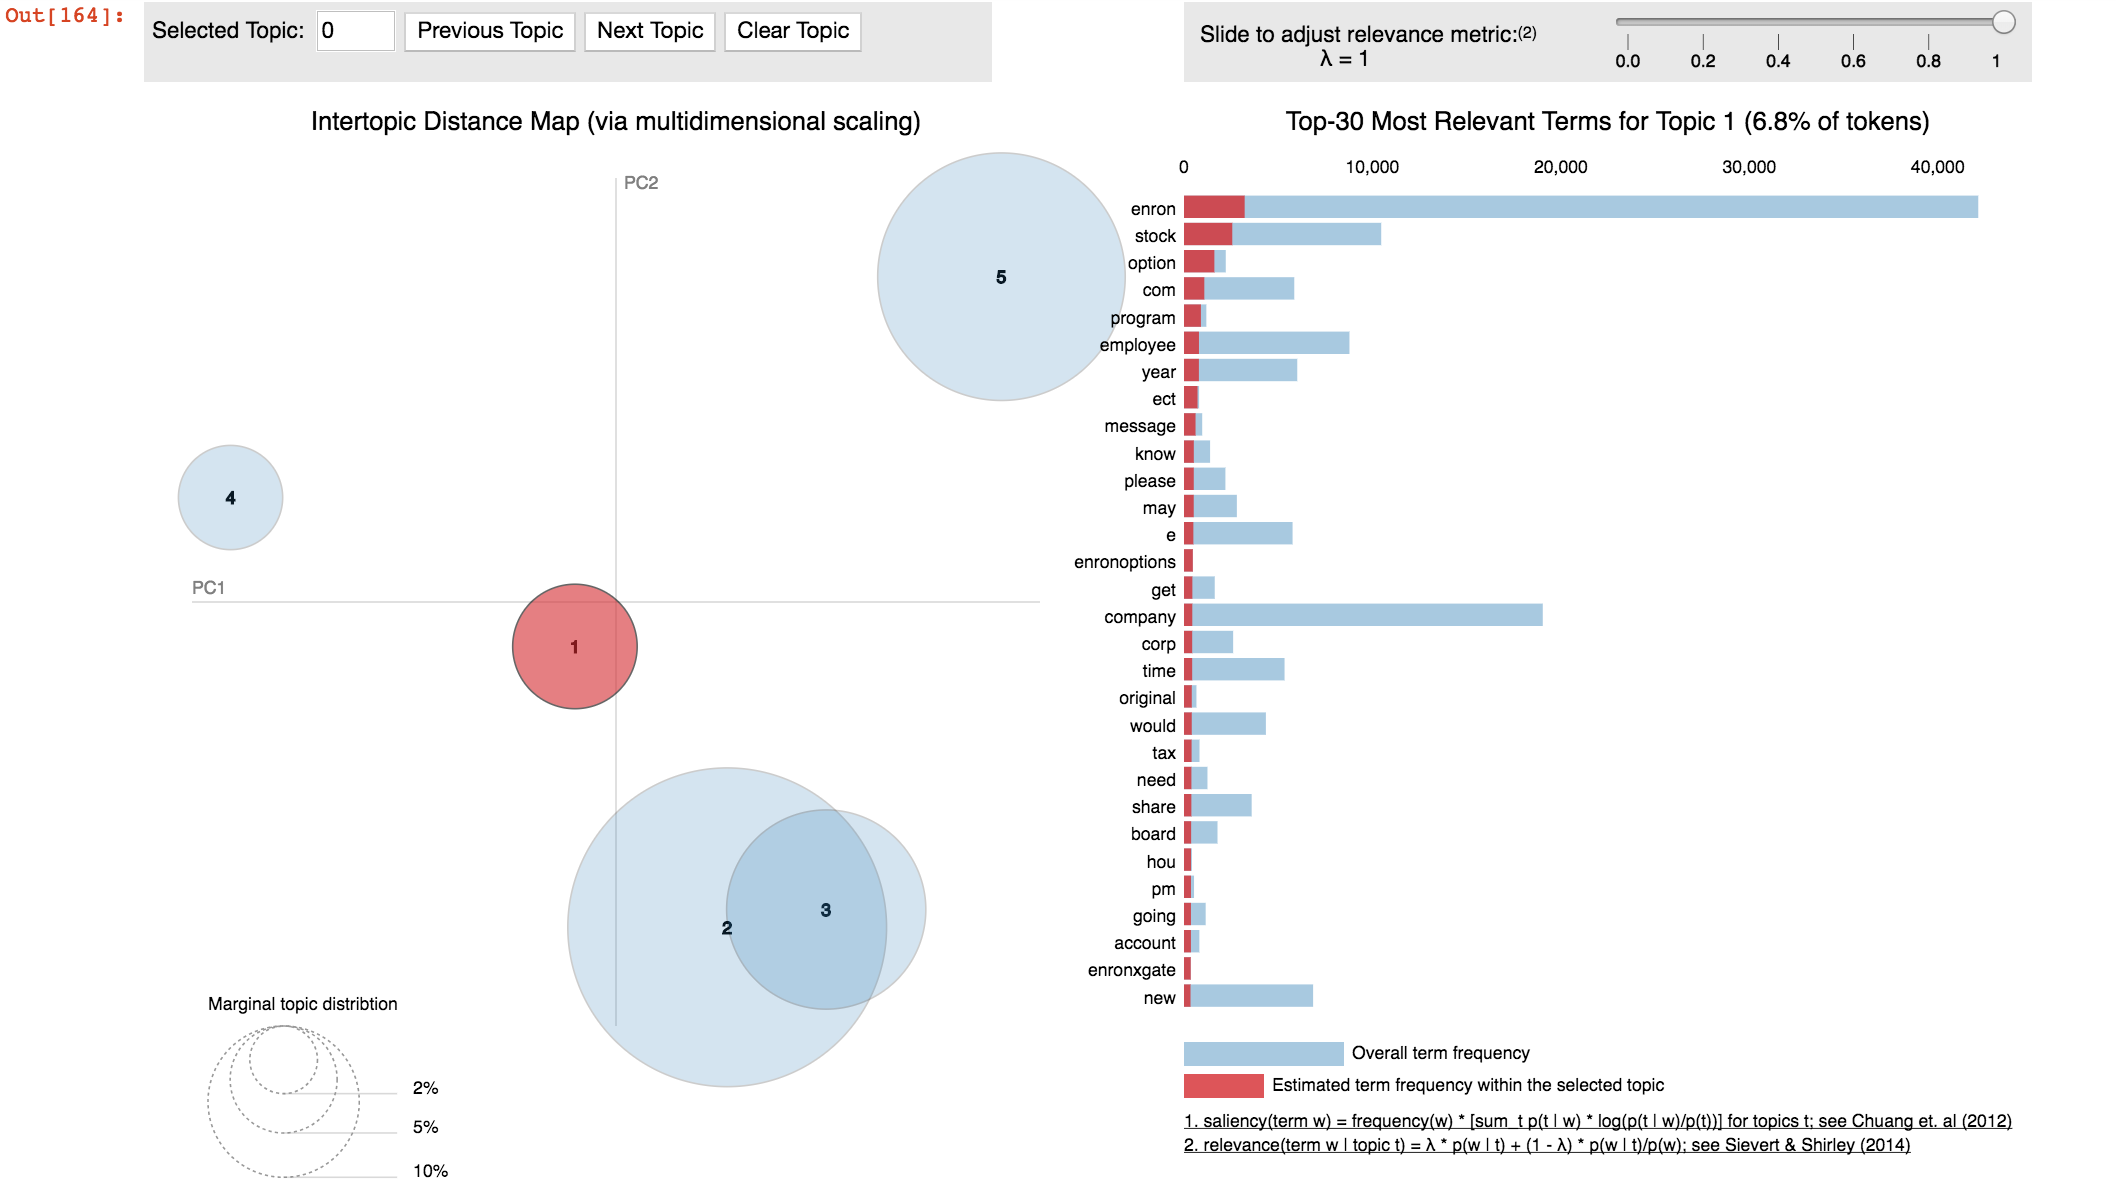

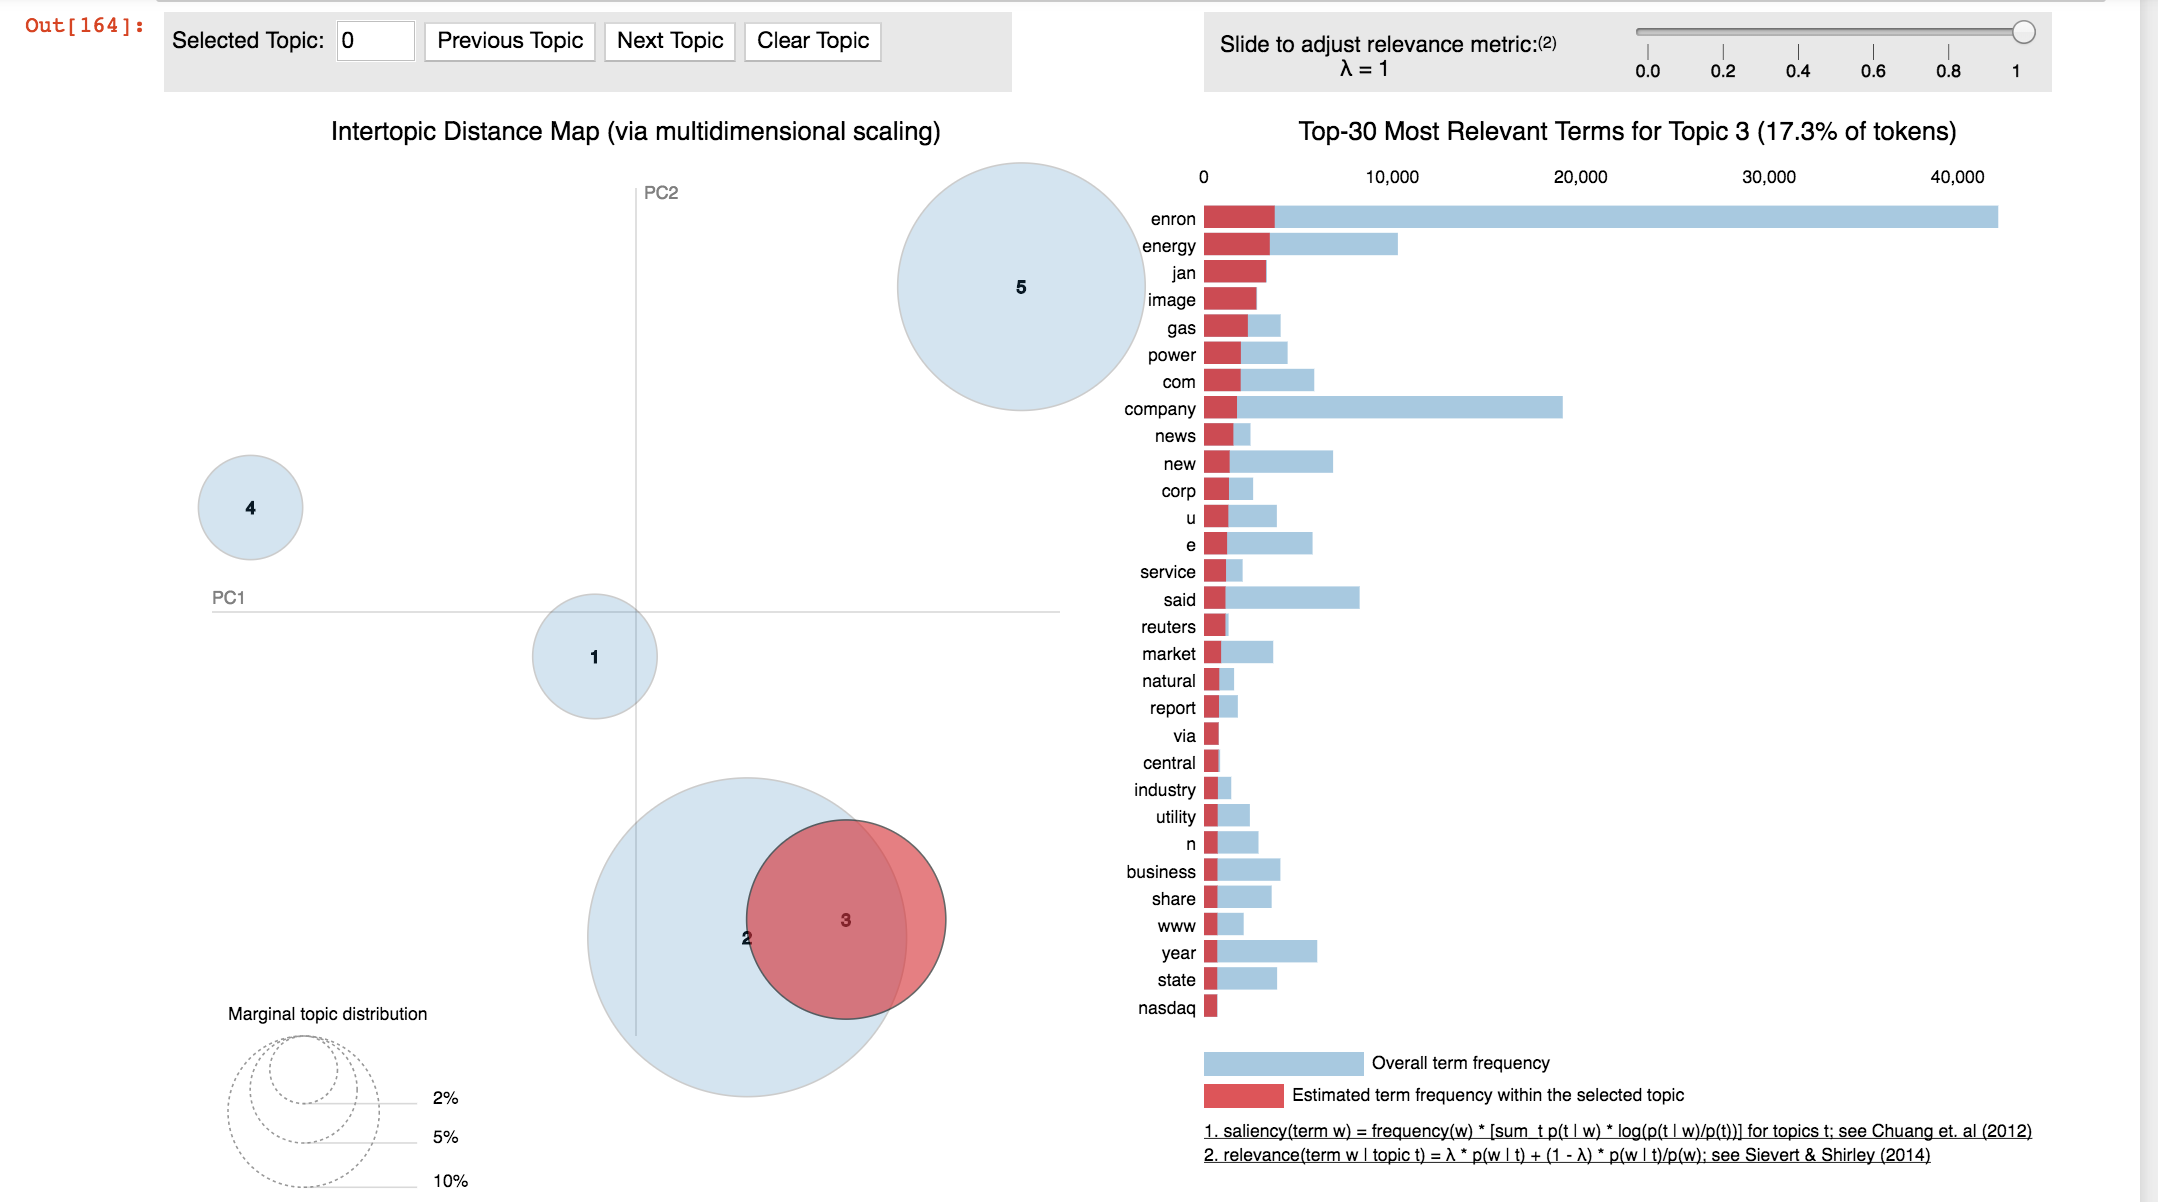

Topic 1 seems to discuss the employee share option program, and seems to point to internal conversation (with "please, may, know" etc), so this is more likely to be related to the internal accounting fraud and trading stock with insider knowledge. Topic 3 seems to be more related to general news around Enron.

### ***Finding fraudsters based on topic***

You're going to link the results from the topic model back to your original data. You now learned that you want to flag everything related to topic 3. As you will see, this is actually not that straightforward. You'll be given the function `get_topic_details()` which takes the arguments `ldamodel` and `corpus`. It retrieves the details of the topics for each line of text. With that function, you can append the results back to your original data. If you want to learn more detail on how to work with the model results, which is beyond the scope of this course, you're highly encouraged to read this [article](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/).

Available for you are the `dictionary` and `corpus`, the text data `text_clean` as well as your model results `ldamodel`. Also defined is `get_topic_details()`.

* Print and inspect the results from the `get_topic_details()` function by inserting your LDA model results and `corpus`.
* Concatenate column-wise the results from the previously defined function `get_topic_details()` to the original text data contained under `contents` and inspect the results.
* Create a flag with the **`np.where()`** function to flag all content that has topic 3 as a dominant topic with a `1`, and `0` otherwise




In [62]:
def get_topic_details(ldamodel, corpus):
    topic_details_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                topic_details_df = topic_details_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
    topic_details_df.columns = ['Dominant_Topic', '% Score', 'Topic_Keywords']
    return topic_details_df

display(get_topic_details(ldamodel, corpus))

# Add original text to topic details in a dataframe : ทำไม่ได้ เพราะ text_clean เรามีแค่ 5 ตัว
contents = pd.DataFrame({'Original text': text_clean})
topic_details = pd.concat([get_topic_details(ldamodel, corpus), contents], axis=1)
print(topic_details.head())

# Add original text to topic details in a dataframe
contents = pd.DataFrame({'Original text':text_clean})
topic_details = pd.concat([get_topic_details(ldamodel, corpus), contents], axis=1)

# Create flag for text highest associated with topic 3
topic_details['flag'] = np.where((topic_details['Dominant_Topic'] == 3.0), 1, 0)
print(topic_details.head())


,Dominant_Topic,% Score,Topic_Keywords
0,2.0,0.9992,"financial, half, public, office, dark, shop, c..."
1,1.0,0.9990,"category, problem, interested, mo, sole, pay, ..."
2,1.0,0.9944,"category, problem, interested, mo, sole, pay, ..."
3,4.0,0.9935,"category, fisher, office, policy, percentage, ..."
4,4.0,0.9934,"category, fisher, office, policy, percentage, ..."


You have now flagged all data that is highest associated with topic 3, that seems to cover internal conversation about enron stock options. You are a true detective. With these exercises you have demonstrated that text mining and topic modeling can be a powerful tool for fraud detection.